#### Importing the needed libraries

In [2]:
import numpy as np
import pandas as pd

import contextlib
import warnings

from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import pickle
import random
warnings.filterwarnings("ignore", "Creating an ndarray from ragged")

### Loading the data

We will then load the prepared data defined by the least cloudy RGB source images across all labels taken quarterly throughout the year (every three months).

In [3]:
tmp_dir=!pwd
tmp_dir=tmp_dir[0]

In [3]:
tmp_dir

'/home/jovyan/PlanetaryComputerExamples/landcovnet'

In [4]:
with open (f'{tmp_dir}/items.pkl', 'rb') as fp:
    Xys = pickle.load(fp)

Next, we will extract the images and labels respectively.

Since we extracted three RGB images from each season from the data preparation notebook, we will combine/concatenate those images into a single numpy array consisting of (3x3)= 9 bands

In [5]:
def process_xy(Xys): #process x and y
    total=0
    temp=[]
    total_list=[]
    for i in range (0, len(Xys)):
        temp.append(Xys[i][0].data)
    for i in range(0,len(Xys)):
        total+=len(Xys[i][0])
        total_list.append(total) #this saves the index of the label's first image, then the next label's first image, etc.
    # print(temp.shape)
    for i in range(0,len(total_list)-1):
        if total_list[i+1]!=total_list[i]+3: #the label does not contain four source images
            outlier=total_list[i]
    temp = [it for sub in temp for it in sub]
    temp = np.asarray(temp)
    temp = temp.swapaxes(1,2) #transform axis to desired shape
    temp = temp.swapaxes(2,3)
    X_mod=[]
    for item in range(0,len(temp)):
        if item==outlier:
            pass
        else:
            X_mod.append(list(temp[item]))
    del temp
    del total_list
    X_mod=np.asarray(X_mod)
    flat_list=[]
    for i in range(0,len(X_mod),3):
        flat_list.append(list(np.concatenate(X_mod[i:i+3], axis=2)))#roll the data  
    flat_list=np.asarray(flat_list)
    del X_mod
    Y= np.zeros((len(Xys), 256, 256), dtype=np.float32)
    i=0
    for j in range(0,len(Xys)): #labels for the source images belonging to a label item
        Y[j]=Xys[j][1][0].data
        #i+=1
        # Y[j][:,:,0] = Xys[j][1][0].data # same value in each channel
        # Y[j][:,:,1] = Xys[j][1][0].data
        # Y[j][:,:,2] = Xys[j][1][0].data
        # Y[j][:,:,3] = Xys[j][1][0].data
        # Y[j][:,:,4] = Xys[j][1][0].data
        # Y[j][:,:,5] = Xys[j][1][0].data
        # Y[j][:,:,6] = Xys[j][1][0].data
        # Y[j][:,:,7] = Xys[j][1][0].data
        # Y[j][:,:,8] = Xys[j][1][0].data
    return flat_list,Y

In [6]:
X,Y=process_xy(Xys) #extract x and y

#### Splitting the data

We will split the data into three non-overlapping data sets; the training, validation and test data sets.

Much of the training will be on the training set, containing 70% of the data, while the validation and test sets will contain 30% of the data (15% each).

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)
del X #clear memory
del Y

In [8]:
import gc
gc.collect()

0

In [8]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(1386, 256, 256, 9)
(1386, 256, 256)
(297, 256, 256, 9)
(297, 256, 256)
(297, 256, 256, 9)
(297, 256, 256)


We will just make a sanity check by visualising a random training image and its label to make sure they fit

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


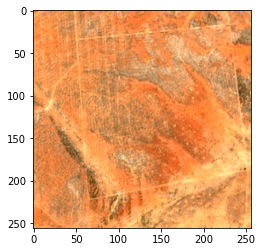

In [28]:
#view a random image
train_id = random.randint(0, len(train_id)-1)
plt.imshow(x_train[train_id][:,:,3:6]*2) #chose the second image [3:6] in the concatenated image

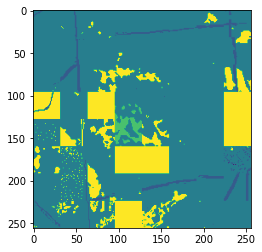

In [25]:
plt.imshow(y_train[train_id]) #display corresponding label

#### Building the U-Net architecture
This model was thanks to YOUCEF GUICHI on Kaggle's  Aerial Semantic Segmentation Drone Dataset.

Their implementation can be found [here](https://www.kaggle.com/yesa911/aerial-semantic-segmentation-96-acc).

For this tutorial, some tweaks were made on the referenced implementation to suit our application

In [10]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    #code reference: https://www.kaggle.com/yesa911/aerial-semantic-segmentation-96-acc
    conv = Conv2D(n_filters, 
                  kernel_size = 3,     
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(inputs)
    conv = Conv2D(n_filters, 
                  kernel_size = 3, 
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(conv)

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

def upsampling_block(expansive_input, contractive_input, n_filters=32):
    
    up = Conv2DTranspose(
                 n_filters,  
                 kernel_size = 3,
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,   
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(merge)
    
    conv = Conv2D(n_filters,  
                 kernel_size = 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(conv)
    
    
    return conv

In [11]:
def unet_model(input_size=(256, 256, 3), n_filters=32, n_classes=8):
    #code reference: https://www.kaggle.com/yesa911/aerial-semantic-segmentation-96-acc
    inputs = Input(input_size)
    #inputs = BatchNormalization()(inputs) # we can learn the normalization step
    #inputs = Dropout(0.5)(inputs)    
    #contracting path
    cblock1 = conv_block(inputs, n_filters)
    
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    
    cblock3 = conv_block(cblock2[0], 4*n_filters)
    
    cblock4 = conv_block(cblock3[0], 8*n_filters, dropout_prob=0.3) 
    
    cblock5 = conv_block(cblock4[0],16*n_filters, dropout_prob=0.3, max_pooling=None)  
    
    #expanding path
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  8 * n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7,cblock2[1] , n_filters*2)
    ublock9 = upsampling_block(ublock8,cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    #conv9 = BatchNormalization()(conv9)
    conv10 = Conv2D(n_classes, kernel_size=1, padding='same')(conv9)  
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [13]:
img_height = 256
img_width = 256
num_channels = 9 #modify since we have 9 channels instead

unet = unet_model((img_height, img_width, num_channels))

In [14]:
unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 9) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 32) 2624        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 256, 256, 32) 9248        conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_21[0][0]                  
____________________________________________________________________________________________

In [19]:
#save the model based on best validation loss
model_checkpoint = ModelCheckpoint(tmp_dir+'/unet_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
#stop training if no improvements after 50 epochs
model_earlyStopping = EarlyStopping(min_delta= 0.001, patience=50)

In [22]:
#setting up and compiling the model
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0003, name="Adam"
)
loss= loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
unet.compile(optimizer=optimizer, loss= loss,\
                  metrics = ['accuracy'])

In [23]:
batch_size=16
history = unet.fit(x=x_train, y=y_train,
              validation_data=(x_val, y_val),
              steps_per_epoch = len(x_train)//batch_size,
              validation_steps = len(x_val)//batch_size,
              batch_size=batch_size, epochs=100, callbacks=[model_checkpoint, model_earlyStopping])

2022-02-28 23:48:55.446867: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3269984256 exceeds 10% of free system memory.
2022-02-28 23:48:55.943699: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-28 23:48:55.965384: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2445410000 Hz


Epoch 1/100


2022-02-28 23:48:56.933316: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-02-28 23:48:59.621233: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-02-28 23:48:59.772307: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-02-28 23:49:01.455656: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


86/86 [==============================] - 123s 337ms/step - loss: 1.7958 - accuracy: 0.3338 - val_loss: 1.5575 - val_accuracy: 0.3477

Epoch 00001: val_loss improved from inf to 1.55745, saving model to /home/jovyan/PlanetaryComputerExamples/landcovnet/unet_model.hdf5
Epoch 2/100
86/86 [==============================] - 118s 328ms/step - loss: 1.5182 - accuracy: 0.3648 - val_loss: 1.5356 - val_accuracy: 0.3547

Epoch 00002: val_loss improved from 1.55745 to 1.53557, saving model to /home/jovyan/PlanetaryComputerExamples/landcovnet/unet_model.hdf5
Epoch 3/100
86/86 [==============================] - 28s 329ms/step - loss: 1.4885 - accuracy: 0.3681 - val_loss: 1.5318 - val_accuracy: 0.3553

Epoch 00003: val_loss improved from 1.53557 to 1.53175, saving model to /home/jovyan/PlanetaryComputerExamples/landcovnet/unet_model.hdf5
Epoch 4/100
86/86 [==============================] - 28s 332ms/step - loss: 1.4986 - accuracy: 0.3635 - val_loss: 1.5306 - val_accuracy: 0.3552

Epoch 00004: val_los

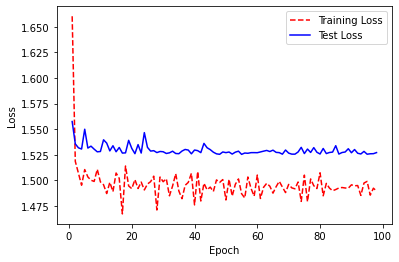

In [24]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

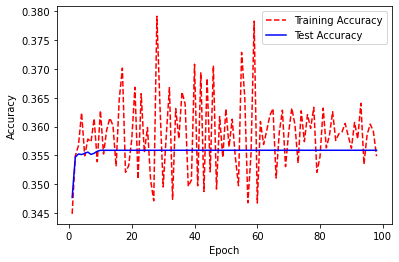

In [25]:
# Get training and test loss histories
training_loss = history.history['accuracy']
test_loss = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

Next, we will load the model to make predictions

In [10]:
loaded_model = tf.keras.models.load_model(tmp_dir+'/unet_model.hdf5')

In [12]:
import random
i=random.randint(0, len(x_train)-1)
pred_mask = loaded_model.predict(np.expand_dims(x_train[i], 0))
pred_mask = np.argmax(pred_mask, axis=-1)
pred_mask = pred_mask[0]

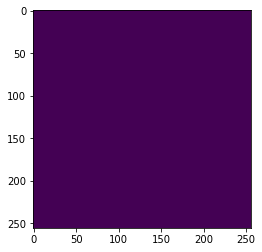

In [13]:
plt.imshow(pred_mask)

Next, we will visualise the model results on the test set, showing the true image, the true label and the predicted label

In [18]:
i=random.randint(0, len(x_test)-1)
test_result= loaded_model.evaluate(np.expand_dims(x_test[i], 0),np.expand_dims(y_test[i], 0))

1/1 [==============================] - 0s 25ms/step - loss: 1.8490 - accuracy: 0.2340


1/1 [==============================] - 0s 26ms/step - loss: 1.3529 - accuracy: 0.7004


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1.3529329299926758, 0.7004241943359375]
3


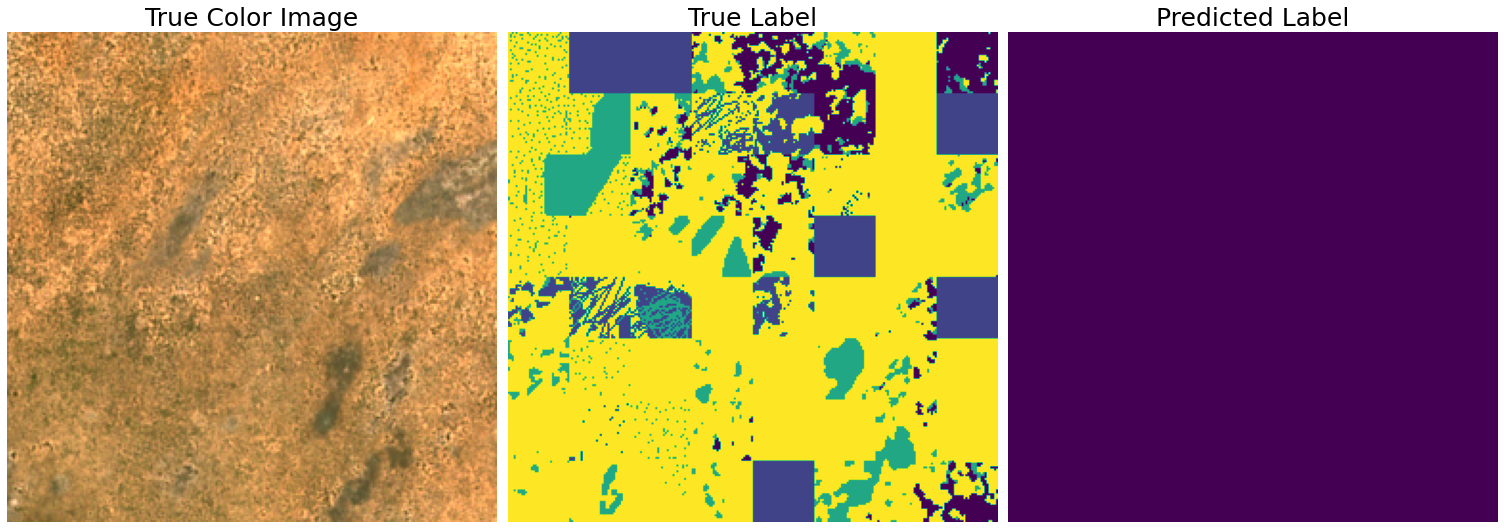

In [22]:
import random
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(21,10.80))
i=random.randint(0, len(x_test)-1)
test_result= loaded_model.evaluate(np.expand_dims(x_test[i], 0),np.expand_dims(y_test[i], 0))
pred_mask = loaded_model.predict(np.expand_dims(x_test[i], 0))
pred_mask = np.argmax(pred_mask, axis=-1)
pred_mask = pred_mask[0]
print(test_result) #print results on the random field
print (i) #print ID
# Perform a sanity check on some random training samples
plt.subplot(1, 3, 1)
fontsize =25
axes[0].imshow((x_test[i][:,:,0:3])*2) #display first image
plt.title("True Color Image", fontdict={'fontsize': fontsize})
plt.axis('off')
plt.subplot(1, 3, 2)
axes[1].imshow(y_test[i])
plt.title("True Label", fontdict={'fontsize': fontsize})
plt.axis('off')
plt.subplot(1,3,3)
axes[2].imshow(pred_mask) #prediction without threshold
plt.title("Predicted Label", fontdict={'fontsize': fontsize})
plt.axis('off')
fig.tight_layout()

#### Future Work

There appears to be some class imbalance in the data as majority of the pixels fall under label 8 (index 7). This represents about 30% of the data as shown:

In [24]:
(unique,counts)=np.unique(y_train,return_counts=True)
print(unique,counts)
sum=0
percentage=[]
for i in counts:
    sum+=i
for i in counts:
    percentage.append(((i/sum)*100))
percentage

[0. 1. 2. 3. 4. 5. 6. 7.] [   68451  1996871  2451778 15068808    68629 24191081 14130223 32857055]


[0.07535926191321698,
 2.198400676336467,
 2.6992181334832703,
 16.589593268060064,
 0.07555522615947421,
 26.63251097928222,
 15.556283705850356,
 36.17307874891493]

We can see it in the calculation that it covers 36% of the data, while class 1 represents a meagre 0.075% of the data.

Hence, a possible improvement to the model would be to take this class imbalance into account for model training